# Selection Bias

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pymc as pm
import arviz as az
import xarray as xr

from utils import value_counts, decorate

from scipy.special import expit


In [3]:
# Make the figures smaller to save some screen real estate
plt.rcParams["figure.dpi"] = 75
plt.rcParams["figure.figsize"] = [6, 3.5]
plt.rcParams["axes.titlelocation"] = "left"

## Robust version

Data from https://fairnessmeasures.github.io/Pages/DatasetPages/SAT.html

Zehlike, Meike, Carlos Castillo, Francesco Bonchi, Ricardo Baeza-Yates, Sara Hajian, Mohamed Megahed. “Fairness Measures: Datasets and software for detecting algorithmic discrimination.” June, 2017. http://fairness-measures.org/ [bibtex]

Ultimately from https://web.archive.org/web/20170302091900/https://research.collegeboard.org/programs/sat/data/archived/cb-seniors-2014 ?


In [4]:
!tail sat-percentile-ranks-mathematics-2015-Group-Data.csv

1681146;1682924;240;1779;;1
1682925;1685217;240;2293;1;1
1685218;1686643;230;1426;;1
1686644;1688534;230;1891;1;1
1688535;1689529;220;995;;1_
1689530;1690889;220;1360;1;1_
1690890;1691960;210;1071;;1_
1691961;1693356;210;1396;1;1_
1693357;1695812;200;2456;;�
1695813;1698521;200;2709;1;�

In [46]:
sat_2014 = pd.read_csv('sat-percentile-ranks-mathematics-2014-group-data.csv', 
                      sep=';', encoding='cp1252')


def read_sat_2015():
    sat = pd.read_csv('sat-percentile-ranks-mathematics-2015-Group-Data.csv', 
                      sep=';', encoding='cp1252')
    sat = sat.drop(index=0)
    sat.columns = sat.columns.str.lower()
    sat['sex'] = sat['sex'].fillna(0)
    return sat

sat_2015 = read_sat_2015()

In [120]:
sat = sat_2014

In [121]:
sat.head()

,from,to,score,delta,sex,Percentile (w respect to sex)
0,1,9835,800,9835,0,99
1,9836,14677,800,4842,1,99
2,14678,17098,790,2421,0,98
3,17099,18505,790,1407,1,99
4,18506,20061,780,1556,0,98


In [122]:
sat.tail()

,from,to,score,delta,sex,Percentile (w respect to sex)
117,1663455,1664260,220,806,1,1-
118,1664261,1665430,210,1170,0,1-
119,1665431,1666863,210,1433,1,1_
120,1666864,1669522,200,2659,0,Ñ
121,1669523,1672395,200,2873,1,Ñ


In [123]:
full_thetas = np.arange(100, 910, 10)
full_thetas

array([100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220,
       230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350,
       360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480,
       490, 500, 510, 520, 530, 540, 550, 560, 570, 580, 590, 600, 610,
       620, 630, 640, 650, 660, 670, 680, 690, 700, 710, 720, 730, 740,
       750, 760, 770, 780, 790, 800, 810, 820, 830, 840, 850, 860, 870,
       880, 890, 900])

In [124]:
left_mask = full_thetas < 200
right_mask = full_thetas > 800
center_mask = (full_thetas >= 200) & (full_thetas <= 800)

In [125]:
# Discrete scores
thetas = full_thetas[center_mask]
thetas

array([200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320,
       330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450,
       460, 470, 480, 490, 500, 510, 520, 530, 540, 550, 560, 570, 580,
       590, 600, 610, 620, 630, 640, 650, 660, 670, 680, 690, 700, 710,
       720, 730, 740, 750, 760, 770, 780, 790, 800])

In [126]:
thetas_centered = thetas - 500
thetas_centered

array([-300, -290, -280, -270, -260, -250, -240, -230, -220, -210, -200,
       -190, -180, -170, -160, -150, -140, -130, -120, -110, -100,  -90,
        -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10,    0,   10,   20,
         30,   40,   50,   60,   70,   80,   90,  100,  110,  120,  130,
        140,  150,  160,  170,  180,  190,  200,  210,  220,  230,  240,
        250,  260,  270,  280,  290,  300])

In [127]:
from empiricaldist import Pmf

def get_counts(sat, sex):
    subset = sat.query('sex == @sex')
    ps = subset['delta'].astype(int).values
    qs = subset['score']
    counts = Pmf(ps, qs)
    return counts

In [128]:
counts_male = get_counts(sat, 0)
counts_female = get_counts(sat, 1)

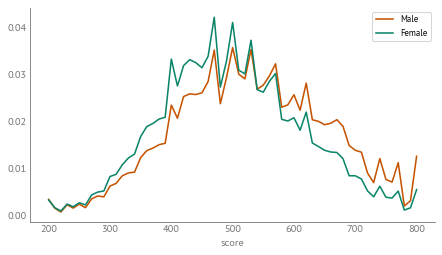

In [129]:
pmf = counts_male.copy()
pmf.normalize()
pmf.plot(label='Male')

pmf = counts_female.copy()
pmf.normalize()
pmf.plot(label='Female')

decorate()

In [130]:
# prepare the data
counts = counts_male
observed_counts = counts.reindex(thetas, fill_value=0).to_numpy()
observed_counts

array([ 2659,  1170,   552,  1755,  1195,  1859,  1261,  2736,  3216,
        3072,  4862,  5324,  6578,  7054,  7189,  9615, 10785, 11198,
       11772, 12008, 18374, 16185, 19800, 20255, 20138, 20432, 22309,
       27559, 18608, 22973, 27979, 23531, 22748, 27650, 21001, 21714,
       23259, 25262, 18017, 18419, 20098, 17525, 22042, 15928, 15666,
       15106, 15342, 15943, 14823, 11643, 10841, 10523,  7034,  5439,
        9460,  5966,  5532,  8774,  1556,  2421,  9835])

In [131]:
N_test_obs = int(observed_counts.sum())

# Assuming for now that half of all high school seniors took the test
N_total = N_test_obs * 2
N_total, N_test_obs

(1567140, 783570)

In [162]:
import pytensor.tensor as pt 

with pm.Model() as model:
    # Latent population score distribution
    mu = pm.Normal("mu", mu=500, sigma=30)
    sigma = pm.Gamma("sigma", alpha=20, beta=0.2)

    # Compute population distribution (normalized logpdf)
    logp_vals = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
    log_noise = pm.Normal("log_noise", mu=0.0, sigma=0.02, shape=logp_vals.shape)
    logp_normalizer = pm.math.logsumexp(logp_vals + log_noise)
    pop_pdf = pm.math.exp(logp_vals - logp_normalizer)
    
    left_mass = pop_pdf[left_mask].sum()
    right_mass = pop_pdf[right_mask].sum()
    center_pdf = pop_pdf[center_mask]
    
    center_pdf = pt.set_subtensor(center_pdf[0], center_pdf[0] + left_mass)
    center_pdf = pt.set_subtensor(center_pdf[-1], center_pdf[-1] + right_mass)

    # Selection model: logistic function
    alpha = pm.Normal("alpha", mu=0, sigma=0.1)
    beta = pm.Normal("beta", mu=0, sigma=0.01)

    logits = alpha + beta * thetas_centered / 30
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker score distribution
    test_unnorm = center_pdf * p_take
    prob_test = pm.math.sum(test_unnorm)
    test_pdf = test_unnorm / pm.math.sum(test_unnorm)

    # Binomial likelihood for number of test-takers
    pm.Binomial("N_test", n=N_total, p=prob_test, observed=N_test_obs)

    # Multinomial likelihood for binned scores
    pm.Multinomial("obs_bins", n=N_test_obs, p=test_pdf, observed=observed_counts)

    idata = pm.sample_prior_predictive(1000)

Sampling: [N_test, alpha, beta, log_noise, mu, obs_bins, sigma]


In [163]:
with model:
    idata = pm.sample(target_accept=0.8)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, log_noise, alpha, beta]


Output()

/home/downey/miniconda3/envs/SelectionSAT/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [164]:
pm.summary(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,522.410,1.428,519.861,525.109,0.032,0.020,2017.0,2526.0,1.0
sigma,125.524,0.145,125.248,125.787,0.003,0.002,2517.0,2939.0,1.0
alpha,-0.022,0.007,-0.035,-0.010,0.000,0.000,2096.0,2416.0,1.0
beta,0.032,0.005,0.022,0.042,0.000,0.000,2037.0,2436.0,1.0


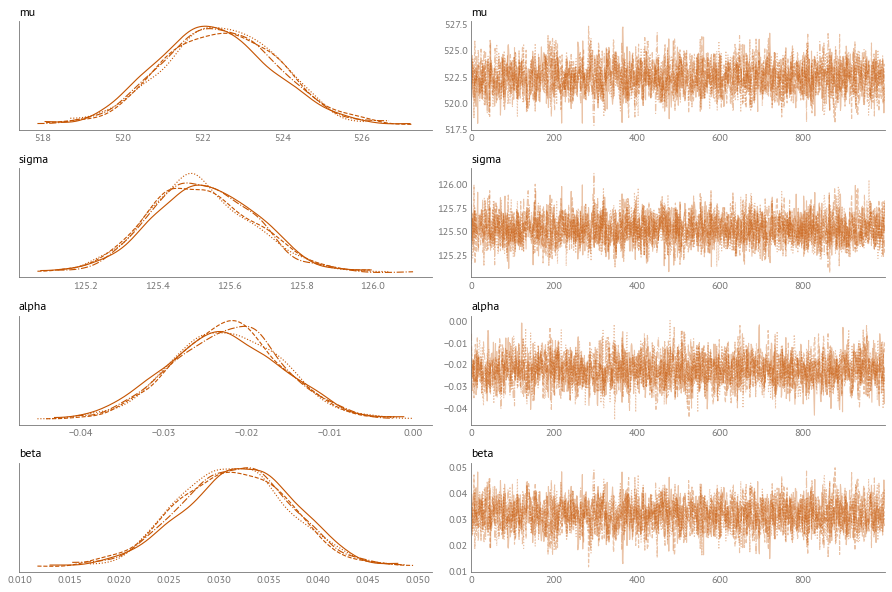

In [165]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])
decorate()

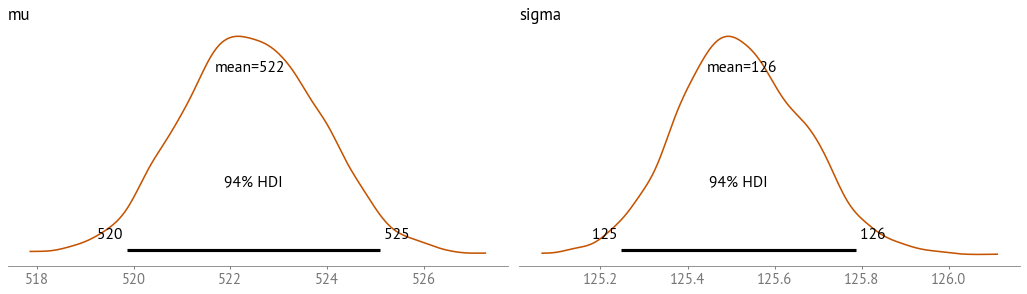

In [166]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

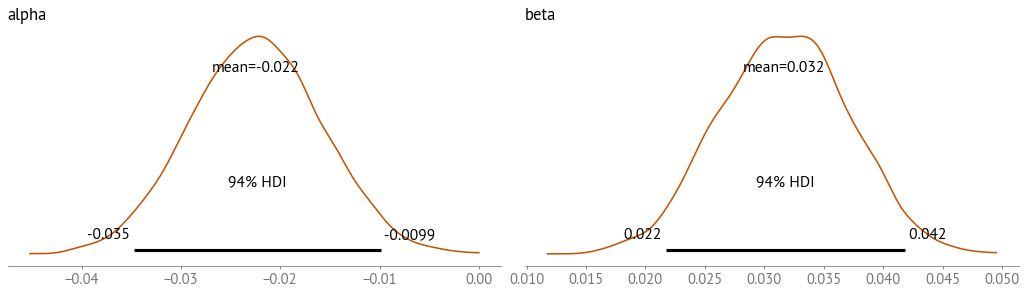

In [167]:
pm.plot_posterior(idata, var_names=['alpha', 'beta'])
decorate()

In [168]:
#az.plot_forest(idata, var_names='log_noise', combined=True)

In [169]:
def plot_selection_function(idata, col, thetas_centered, **options):
    thetas_xr = xr.DataArray(thetas_centered, dims="theta", coords={"theta": thetas})

    # Extract posterior samples of alpha and beta ---
    posterior = idata.posterior  # shape (chain, draw)

    # Compute logits and apply sigmoid ---
    logits = posterior["alpha"] + posterior["beta"] * thetas_xr
    p = xr.apply_ufunc(expit, logits)

    # Compute median and HDI ---
    median_curve = p.median(dim=["chain", "draw"])
    hdi_bounds = az.hdi(p, hdi_prob=0.94)
    low, high = hdi_bounds['x'].T

    # Plot ---
    plt.plot(thetas, median_curve, **options)
    plt.fill_between(
        thetas,
        low,
        high,
        alpha=0.3,
    )    

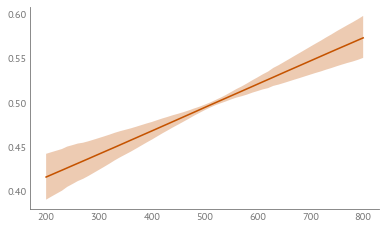

In [170]:
plot_selection_function(idata, 'sat_math', thetas_centered/30)

## Hierarchical

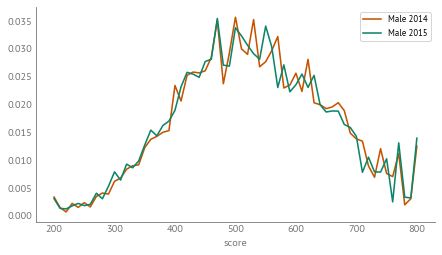

In [75]:
pmf = get_counts(sat_2014, 0)
pmf.normalize()
pmf.plot(label='Male 2014')

pmf = get_counts(sat_2015, 0)
pmf.normalize()
pmf.plot(label='Male 2015')

decorate()

In [70]:
def get_observed_counts(sat, sex):
    counts = get_counts(sat, sex)
    observed_counts = counts.reindex(thetas, fill_value=0).to_numpy()
    return observed_counts

In [72]:
counts_male_2014 = get_observed_counts(sat_2014, sex=0)
counts_male_2015 = get_observed_counts(sat_2015, sex=0)

In [39]:
import pytensor.tensor as pt 

with pm.Model() as model:
    # Latent population score distribution
    mu = pm.Normal("mu", mu=500, sigma=30)
    sigma = pm.Gamma("sigma", alpha=20, beta=0.2)

    # Compute population distribution (normalized logpdf)
    logp_vals = pm.logp(pm.Normal.dist(mu=mu, sigma=sigma), full_thetas)
    log_noise = pm.Normal("log_noise", mu=0.0, sigma=0.02, shape=logp_vals.shape)
    logp_normalizer = pm.math.logsumexp(logp_vals + log_noise)
    pop_pdf = pm.math.exp(logp_vals - logp_normalizer)
    
    left_mass = pop_pdf[left_mask].sum()
    right_mass = pop_pdf[right_mask].sum()
    center_pdf = pop_pdf[center_mask]
    
    center_pdf = pt.set_subtensor(center_pdf[0], center_pdf[0] + left_mass)
    center_pdf = pt.set_subtensor(center_pdf[-1], center_pdf[-1] + right_mass)

    # Selection model: logistic function
    alpha = pm.Normal("alpha", mu=0, sigma=2.0)
    beta = pm.HalfNormal("beta", sigma=0.01)

    logits = alpha + beta * thetas_centered
    p_take = pm.Deterministic("p_take", pm.math.sigmoid(logits))

    # Test-taker score distribution
    test_unnorm = center_pdf * p_take
    prob_test = pm.math.sum(test_unnorm)
    test_pdf = test_unnorm / pm.math.sum(test_unnorm)

    # Binomial likelihood for number of test-takers
    pm.Binomial("N_test", n=N_total, p=prob_test, observed=N_test_obs)

    # Multinomial likelihood for binned scores
    pm.Multinomial("obs_bins", n=N_test_obs, p=test_pdf, observed=observed_counts)

    idata = pm.sample_prior_predictive(1000)

Sampling: [N_test, alpha, beta, log_noise, mu, obs_bins, sigma]


TODO: Save traces for male and female, 2014 and 2015

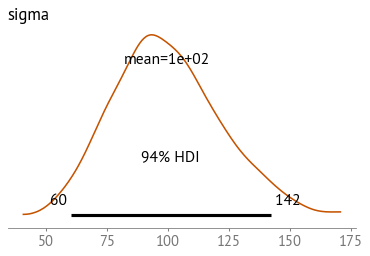

In [40]:
az.plot_posterior(idata, group='prior', var_names='sigma');

In [41]:
with model:
    idata = pm.sample(target_accept=0.96)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma, log_noise, alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 64 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [42]:
pm.summary(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,526.402,1.156,524.260,528.140,0.025,0.019,1954.0,1923.0,1.0
sigma,125.988,0.107,125.793,126.195,0.001,0.002,5962.0,3080.0,1.0
alpha,-0.005,0.005,-0.014,0.003,0.000,0.000,2786.0,2577.0,1.0
beta,0.000,0.000,0.000,0.000,0.000,0.000,1893.0,1570.0,1.0


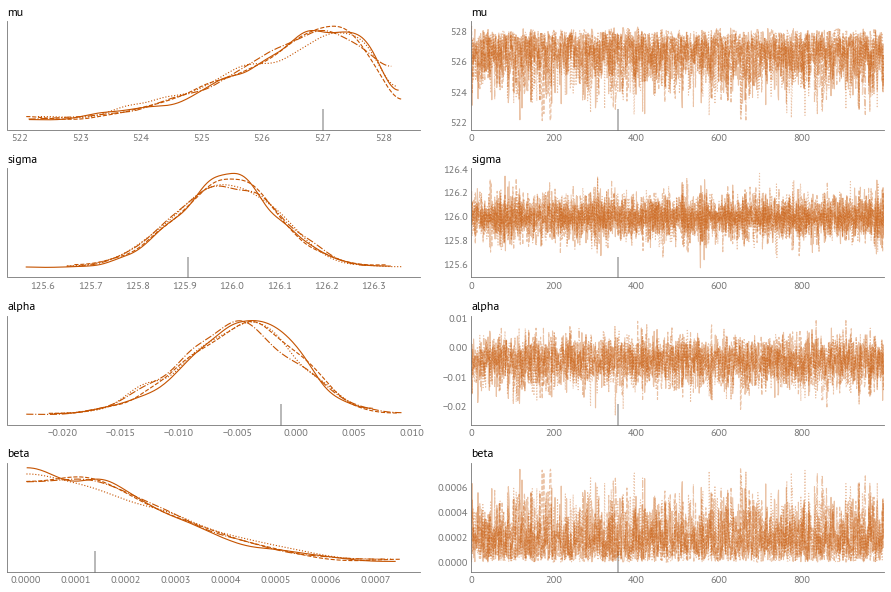

In [43]:
pm.plot_trace(idata, var_names=['mu', 'sigma', 'alpha', 'beta'])
decorate()

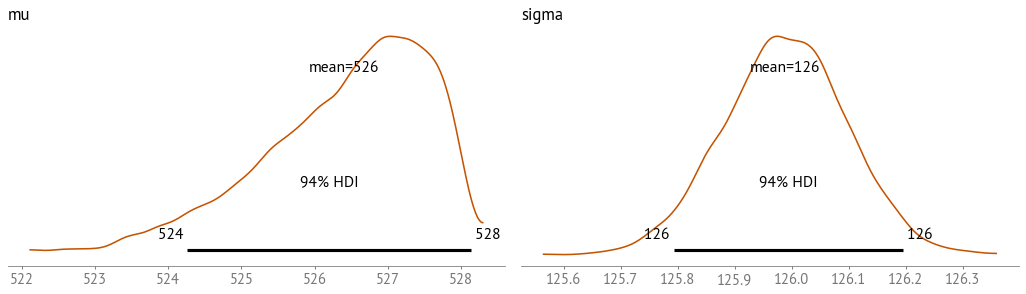

In [44]:
pm.plot_posterior(idata, var_names=['mu', 'sigma'])
decorate()

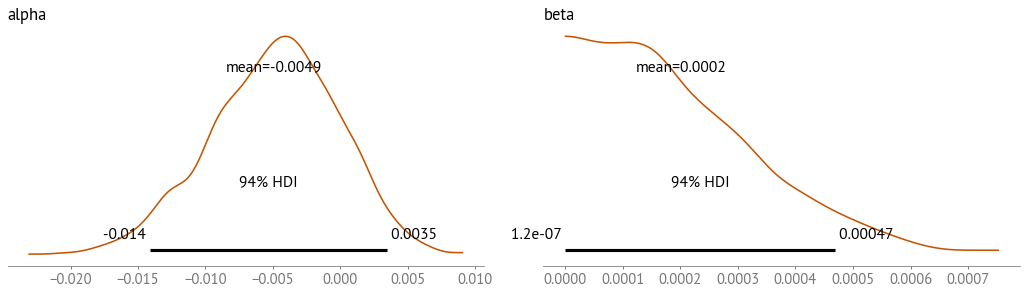

In [45]:
pm.plot_posterior(idata, var_names=['alpha', 'beta'])
decorate()

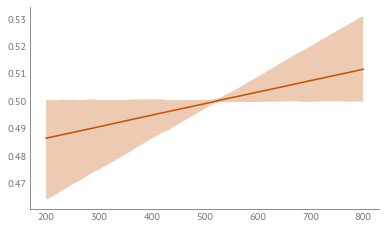

In [24]:
plot_selection_function(idata, 'sat_math', thetas_centered)